# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10393 / 11441 MB available


In [11]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a,float* b,int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][a] + b[j][i]
    unsigned int k = j*cols + i; 
    
    c[k] = a[k]+b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

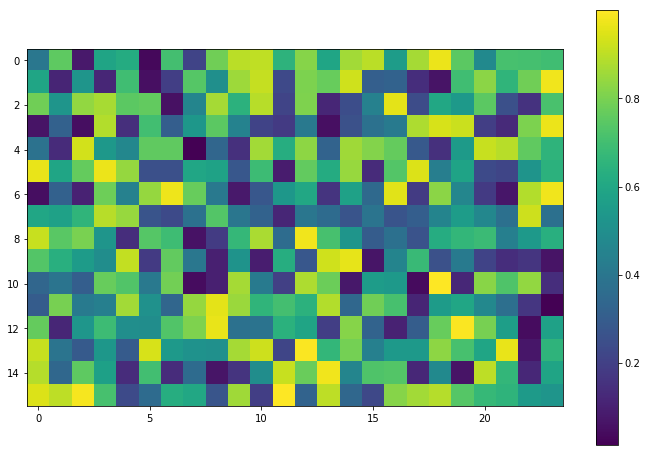

In [14]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [15]:
print(a.shape)

(16, 24)


In [16]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [17]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [28]:
#a.shape = [rows,coloms] [y,x]
domain_size = (a.shape[1], a.shape[0])
block_size = (8,4,1)
grid_size = (domain_size[0] // block_size[0] , domain_size[1] // block_size[1] ,1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 4, 1)
Grid size is (3, 4, 1)


In [30]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.2670252 , 1.2939982 , 0.1795862 , 1.147308  , 1.410474  ,
        0.98971945, 1.0829449 , 0.6922404 , 1.5607575 , 1.3662022 ,
        1.2093141 , 1.3361888 , 1.4843855 , 1.103981  , 1.4601374 ,
        1.2946949 , 1.3074102 , 1.0193341 , 0.97484124, 0.88232833,
        1.0513122 , 1.2449727 , 0.72059864, 0.8919766 ],
       [1.4117284 , 1.1045349 , 1.3405764 , 0.7993507 , 0.9835385 ,
        0.9556308 , 0.22444333, 1.5110801 , 1.3587303 , 0.9559755 ,
        1.6048164 , 0.6743897 , 1.5999377 , 1.0231073 , 1.7769632 ,
        0.40569583, 1.0030105 , 0.2477377 , 0.8222118 , 1.6175578 ,
        1.7014586 , 0.93224084, 1.5960217 , 0.99658793],
       [1.5239207 , 1.4647486 , 1.5938659 , 1.2497057 , 1.7421247 ,
        1.0218006 , 0.9692362 , 1.2762638 , 1.49773   , 0.6892889 ,
        1.6024733 , 0.9851914 , 1.524117  , 1.0122479 , 1.2242451 ,
        1.1313636 , 1.8749399 , 0.827848  , 1.3645414 , 0.8952074 ,
        1.2849805 , 0.97164404, 0.19771793, 0.7703601 ],
       [0.491

In [31]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.2670252  1.2939982  0.1795862  1.147308   1.410474   0.98971945
  1.0829449  0.6922404  1.5607575  1.3662022  1.2093141  1.3361888
  1.4843855  1.103981   1.4601374  1.2946949  1.3074102  1.0193341
  0.97484124 0.88232833 1.0513122  1.2449727  0.72059864 0.8919766 ]
 [1.4117284  1.1045349  1.3405764  0.7993507  0.9835385  0.9556308
  0.22444333 1.5110801  1.3587303  0.9559755  1.6048164  0.6743897
  1.5999377  1.0231073  1.7769632  0.40569583 1.0030105  0.2477377
  0.8222118  1.6175578  1.7014586  0.93224084 1.5960217  0.99658793]
 [1.5239207  1.4647486  1.5938659  1.2497057  1.7421247  1.0218006
  0.9692362  1.2762638  1.49773    0.6892889  1.6024733  0.9851914
  1.524117   1.0122479  1.2242451  1.1313636  1.8749399  0.827848
  1.3645414  0.8952074  1.2849805  0.97164404 0.19771793 0.7703601 ]
 [0.4919056  1.2903811  0.5158356  1.0935092  0.9072558  0.71964216
  1.0266935  0.6733116  1.6995797  0.71483135 0.23652443 0.42175412
  0.6269155  0.51639736 1.0949839  1.2912685  1

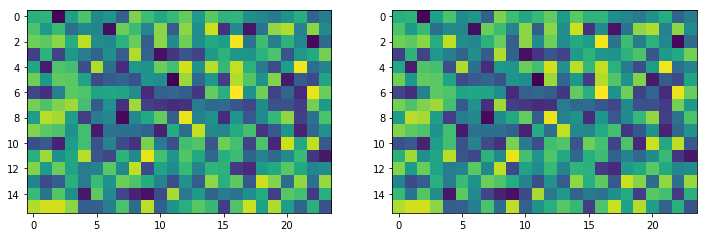

In [33]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)
